In [1]:
# ok maybe we just quasi-randomly sample mix rates, then can plot countor 

# do this for all the toy datasets and waterbirds 

# later we can do it for celebA-0 and multi-nli with mix rate 0.5 

In [2]:
import os 
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

In [3]:
from itertools import product
from pathlib import Path
from datetime import datetime
import copy

import optuna
import numpy as np

from losses.loss_types import LossType
from utils.exp_utils import get_study_args_dict, get_executor, run_experiments
from run_study import get_storage_path

/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
N_TRIALS = 120
NODES_PER_STUDY = 12 # NOTE: this should be 13 but oh well
SAMPLER = "quasi-random"
STUDY_SCRIPT_NAME = "run_study.py"

SCRIPT_NAME = "spur_corr_exp.py"
HPARM_PARENT_DIR = Path("output/cc_mix_rate_lower_bound_sweep")
HPARAM_DIR_NAME = None

if HPARAM_DIR_NAME is None:
    hparam_dir_name = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    hparam_dir = Path(HPARM_PARENT_DIR, hparam_dir_name)
    hparam_dir.mkdir(exist_ok=True, parents=True)
else:
    hparam_dir = Path(HPARM_PARENT_DIR, HPARAM_DIR_NAME)

In [5]:

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_partitions(partitions):
    # Plot each partition as a filled rectangle
    for partition in partitions:
        x_min, y_min, x_max, y_max = partition
        width = x_max - x_min
        height = y_max - y_min
        
        # Create rectangle patch
        rect = Rectangle(
            (x_min, y_min),  # (x,y) of lower-left corner
            width,           # width
            height,         # height
            fill=True,
            alpha=0.2,      # transparency
            edgecolor='black',
            facecolor='gray'
        )
        
        # Add rectangle to plot
        plt.gca().add_patch(rect)

    # Add diagonal line x + y = 1
    x = np.linspace(0, 1, 100)
    y = 1 - x
    plt.plot(x, y, 'r--', label='x + y = 1')

    plt.xlabel('Mix Rate Lower Bound 01')
    plt.ylabel('Mix Rate Lower Bound 10')
    plt.title('Partition Regions')
    plt.grid(True, alpha=0.2)
    plt.axis('equal')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.show()

In [6]:
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]

# using aux weight 1.0 for now

# TODO: add linear schedule

env_configs = {
    "toy_grid": {"dataset": "toy_grid", "model": "toy_model", "epochs": 100, "batch_size": 32, "target_batch_size": 128, "lr": 1e-3, "optimizer": "sgd"},
    "fmnist_mnist": {"dataset": "fmnist_mnist", "model": "Resnet50", "epochs": 5},
    "cifar_mnist": {"dataset": "cifar_mnist", "model": "Resnet50", "epochs": 5},
    "waterbirds": {"dataset": "waterbirds", "model": "Resnet50", "epochs": 5},
#     "celebA-0": {"dataset": "celebA-0", "model": "Resnet50", "epochs": 5},
#     "multi-nli": {"dataset": "multi-nli", "model": "bert", "epochs": 1, "lr": 1e-5, "combine_neut_entail": True, "contra_no_neg": True},
}


hparam_map = {
    "mix_rate_lower_bound_01": {"type": "float", "range": [0, 1], "log": False},
    "mix_rate_lower_bound_10": {"type": "float", "range": [0, 1], "log": False},
}

# PARTITIONS = [
#     [0, 0, 0.25, 0.5], 
#     [0.25, 0, 0.5, 0.5], 
#     [0, 0.5, 0.25, 1], 
#     [0.25, 0.5, 0.5, 1], 
#     [0.5, 0, 0.75, 0.5], 
#     [0.75, 0.0, 1.0, 0.5], 
# ]

PARTITIONS = [
    # Bottom row (left to right)
    [0.0, 0.0, 0.25, 0.25],
    [0.25, 0.0, 0.5, 0.25],
    [0.5, 0.0, 0.75, 0.25],
    [0.75, 0.0, 1.0, 0.25],
    
    # Second row
    [0.0, 0.25, 0.25, 0.5],
    [0.25, 0.25, 0.5, 0.5],
    [0.5, 0.25, 0.75, 0.5],
    [0.75, 0.25, 1.0, 0.5],
    
    # Third row
    [0.0, 0.5, 0.25, 0.75],
    [0.25, 0.5, 0.5, 0.75],
    [0.5, 0.5, 0.75, 0.75],
    # [0.75, 0.5, 1.0, 0.75],
    
    # Top row (excluding rightmost corner partitions)
    [0.0, 0.75, 0.25, 1.0],
    [0.25, 0.75, 0.5, 1.0],
    # [0.5, 0.75, 0.75, 1.0],
    # [0.75, 0.75, 1.0, 1.0],
]



def update_hparam_map(hparam_map, idx):
    new_hparam_map = copy.deepcopy(hparam_map)
    parition = PARTITIONS[idx]
    new_hparam_map["mix_rate_lower_bound_01"]["range"] = [parition[0], parition[2]]
    new_hparam_map["mix_rate_lower_bound_10"]["range"] = [parition[1], parition[3]]
    return new_hparam_map

configs = {}
for (env_name, env_config), mix_rate in product(env_configs.items(), MIX_RATES):
    configs[(env_name, mix_rate)] = {
        **env_config, 
        "mix_rate": mix_rate, 
        "loss_type": LossType.TOPK,
        "mix_rate_lower_bound": None, 
        "mix_rate_schedule": "linear", 
        "mix_rate_t0": 0, 
        "mix_rate_t1": env_config["epochs"]
    }

dataset_to_mem_gb = {
    "toy_grid": 16,
    "fmnist_mnist": 16,
    "cifar_mnist": 16,
    "waterbirds": 16,
    "celebA-0": 32,
    "multi-nli": 32,
}

def get_study_name(env_name, mix_rate):
    return f"{env_name}_{mix_rate}"


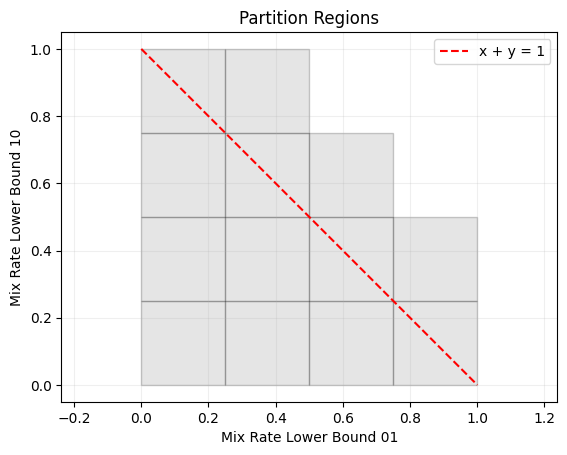

In [7]:
plot_partitions(PARTITIONS)

# Run Experiments

In [7]:
for (env_name, mix_rate), conf in configs.items(): 
    study_name = get_study_name(env_name, mix_rate)
    study_dir = Path(hparam_dir, study_name)
    study_dir.mkdir(exist_ok=True, parents=True)
    
    # create study (must create it here to nodes don't conflict)
    study = optuna.create_study(study_name=study_name, storage=get_storage_path(study_dir), direction="minimize", load_if_exists=True)  
    
    # run study
    n_trials_per_node = N_TRIALS // NODES_PER_STUDY
    cmds = [
        {
            **get_study_args_dict(conf, SCRIPT_NAME, update_hparam_map(hparam_map, i), n_trials_per_node, 0, study_name, study_dir), 
            "sampler_seed": i, 
            "sampler_type": SAMPLER
        } for i in range(NODES_PER_STUDY)
    ]
    executor = get_executor(study_dir, mem_gb=dataset_to_mem_gb[env_name], slurm_array_parallelism=NODES_PER_STUDY)

    jobs = run_experiments(executor, cmds, STUDY_SCRIPT_NAME)

[I 2025-02-04 07:49:50,495] A new study created in RDB with name: toy_grid_0.1
[I 2025-02-04 07:49:50,762] A new study created in RDB with name: toy_grid_0.25
[I 2025-02-04 07:49:50,916] A new study created in RDB with name: toy_grid_0.5
[I 2025-02-04 07:49:51,156] A new study created in RDB with name: toy_grid_0.75
[I 2025-02-04 07:49:51,314] A new study created in RDB with name: toy_grid_1.0
[I 2025-02-04 07:49:51,477] A new study created in RDB with name: fmnist_mnist_0.1
[I 2025-02-04 07:49:51,635] A new study created in RDB with name: fmnist_mnist_0.25
[I 2025-02-04 07:49:51,789] A new study created in RDB with name: fmnist_mnist_0.5
[I 2025-02-04 07:49:51,937] A new study created in RDB with name: fmnist_mnist_0.75
[I 2025-02-04 07:49:52,089] A new study created in RDB with name: fmnist_mnist_1.0
[I 2025-02-04 07:49:52,232] A new study created in RDB with name: cifar_mnist_0.1
[I 2025-02-04 07:49:52,383] A new study created in RDB with name: cifar_mnist_0.25
[I 2025-02-04 07:49:5

# Process Results

In [8]:
# load study 
hparam_dir = "output/cc_mix_rate_lower_bound_sweep/2025-02-04_07-49-39"

In [9]:
# so right now I want to do some exploratory analysis
# for example, for a given dataset and mix rate, plot the max source acc counter grid 
import json
import yaml
import pandas as pd
import numpy as np
# load all metrics in output/cc_mix_rate_lower_bound_sweep into a dataframe 
results = []
for study_dir in Path(hparam_dir).iterdir():
    if not study_dir.is_dir():
        continue
    for exp_dir in study_dir.iterdir():
        if not exp_dir.is_dir():
            continue
        if exp_dir.name == "0":
            continue
        metric_file = exp_dir / "metrics.json"
        config_file = exp_dir / "config.yaml"
        with open(metric_file, "r") as f:
            metrics = json.load(f)
        with open(config_file, "r") as f:
            config = yaml.safe_load(f)
        
        min_val_loss_idx = np.argmin(metrics["val_loss"])
        min_val_loss = metrics["val_loss"][min_val_loss_idx]

        source_acc_0 = metrics["val_source_acc_0"][min_val_loss_idx]
        source_acc_1 = metrics["val_source_acc_1"][min_val_loss_idx]
        max_source_acc = max(source_acc_0, source_acc_1)

        target_acc_0 = metrics["val_target_acc_0"][min_val_loss_idx]
        target_acc_1 = metrics["val_target_acc_1"][min_val_loss_idx]
        max_target_acc = max(target_acc_0, target_acc_1)

        test_acc_0 = metrics["test_acc_0"][min_val_loss_idx]
        test_acc_1 = metrics["test_acc_1"][min_val_loss_idx]
        max_test_acc = max(test_acc_0, test_acc_1)
        
       
        # Create a dictionary for each experiment
        result_dict = {
            'dataset': config["dataset"],
            'mix_rate': config["mix_rate"],
            'mix_rate_lb_01': config["mix_rate_lower_bound_01"],
            'mix_rate_lb_10': config["mix_rate_lower_bound_10"],
            'source_acc': max_source_acc,
            'target_acc': max_target_acc,
            'test_acc': max_test_acc,
            'study_dir': str(study_dir),
            'exp_dir': str(exp_dir)
        }
        results.append(result_dict)

df = pd.DataFrame(results)

In [12]:
df.to_csv(Path(hparam_dir) / "results.csv", index=False)

In [10]:
df

,dataset,mix_rate,mix_rate_lb_01,mix_rate_lb_10,source_acc,target_acc,test_acc,study_dir,exp_dir
0,cifar_mnist,0.25,0.566707,0.076172,0.750000,0.718750,0.717347,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
1,cifar_mnist,0.25,0.801811,0.099609,0.792969,0.800781,0.733673,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
2,cifar_mnist,0.25,0.729444,0.678644,0.949219,0.726562,0.568367,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
3,cifar_mnist,0.25,0.817110,0.374971,0.882812,0.683594,0.592857,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
4,cifar_mnist,0.25,0.101562,0.717299,0.734375,0.648438,0.633673,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
...,...,...,...,...,...,...,...,...,...
2375,waterbirds,0.50,0.324200,0.296930,0.973060,0.867188,0.878840,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
2376,waterbirds,0.50,0.671340,0.738348,0.954741,0.753906,0.759061,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
2377,waterbirds,0.50,0.354256,0.180081,0.971983,0.867188,0.865551,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
2378,waterbirds,0.50,0.160156,0.230469,0.978448,0.851562,0.834657,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...


In [ ]:
# for a given dataset and mix rate, plot conter (with x, y being mix_rate_lb_01 and mix_rate_lb_10, value max source acc)


In [13]:
def plot_mix_rate_accuracy(df, dataset, mix_rate, figsize=(10, 8), vmin=0.5, vmax=1.0):
    """
    Plot scatter of max source accuracy for given dataset and mix rate.
    
    Args:
        df: DataFrame containing the results
        dataset: str, name of dataset to plot
        mix_rate: float, mix rate to plot
        figsize: tuple, size of the figure (width, height)
    """
    import matplotlib.pyplot as plt
    
    # Filter data for specific dataset and mix rate
    mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
    data = df[mask]
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset} and mix_rate={mix_rate}")
        return
    
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    scatter = plt.scatter(
        data['mix_rate_lb_01'], 
        data['mix_rate_lb_10'], 
        c=data['source_acc'],
        cmap='viridis',
        vmin=vmin,  # Set minimum value for color scale
        vmax=vmax,  # Set maximum value for color scale
        s=100  # Point size
    )
    
    # Add colorbar
    plt.colorbar(scatter, label='Max Source Accuracy')
    
    # Labels and title
    plt.xlabel('Mix Rate Lower Bound 01')
    plt.ylabel('Mix Rate Lower Bound 10')
    plt.title(f'Max Source Accuracy\nDataset: {dataset}, Mix Rate: {mix_rate}')
    
    plt.tight_layout()
    plt.show()

In [14]:
# TODO: get ERM mean and std 
mean_source_accs = {
    'celebA-0': 0.996,
    'cifar_mnist': 1.0,
    'fmnist_mnist': 1.0,
    'toy_grid': 0.999,
    'waterbirds': 0.984
}

std_source_accs = {
    'celebA-0': 0.0,
    'cifar_mnist': 0.0,
    'fmnist_mnist': 0.0,
    'toy_grid': 0.002,
    'waterbirds': 0.004
}

In [ ]:
df

Total samples: 500
Number of circles: 66
Mean samples per circle: 23.24
Std samples per circle: 8.50
Min samples per circle: 5
Max samples per circle: 33


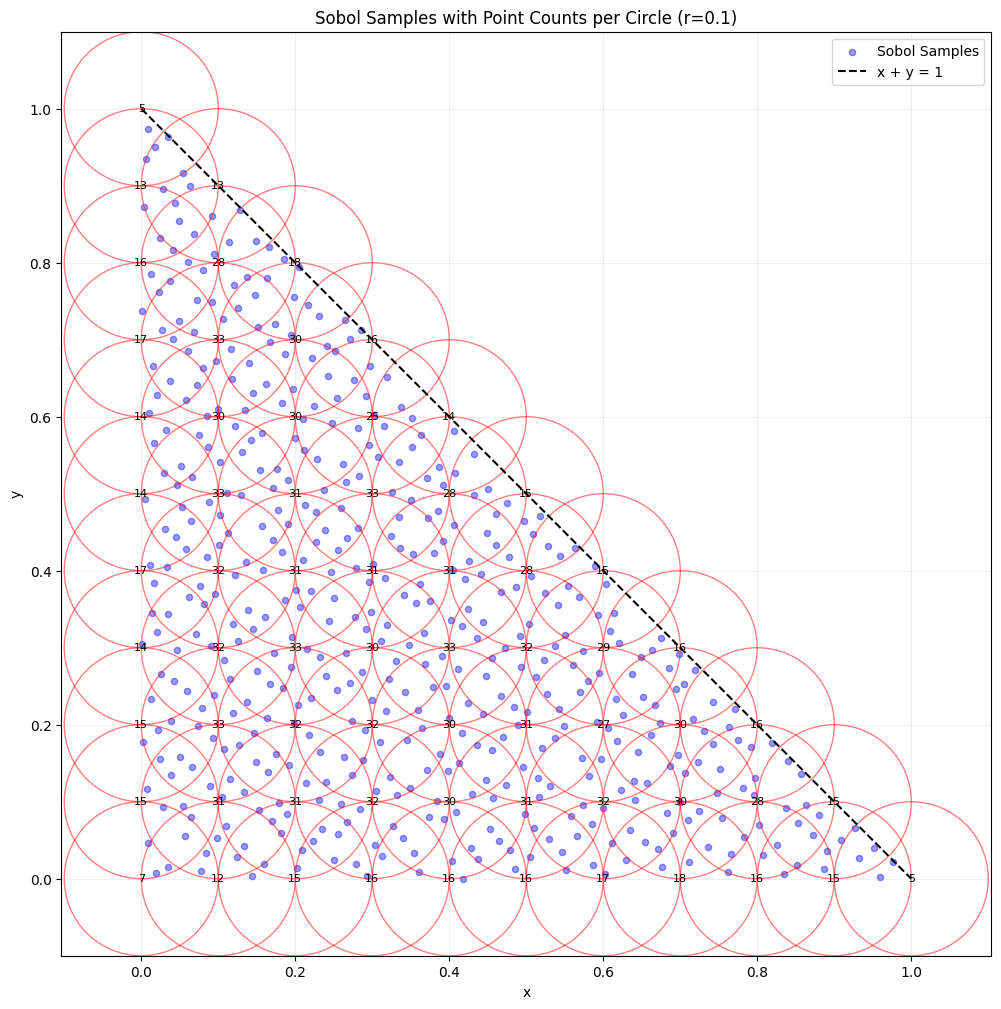

In [36]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

def generate_sobol_samples(n_samples, max_sum=1.0):
    """Generate Sobol samples within triangle where x + y <= 1"""
    sampler = qmc.Sobol(d=2, scramble=True)
    samples = sampler.random(n=n_samples * 2)
    samples *= max_sum
    valid_samples = samples[np.sum(samples, axis=1) <= max_sum]
    return valid_samples[:n_samples]

def create_circle_centers(spacing=0.1):
    """Create centers for circles in a grid pattern"""
    x = np.arange(0, 1.1, spacing)
    y = np.arange(0, 1.1, spacing)
    centers = []
    for i in x:
        for j in y:
            if i + j <= 1:
                centers.append([i, j])
    return np.array(centers)

def count_points_in_circles(samples, centers, radius):
    """Count number of samples within each circle"""
    counts = []
    for center in centers:
        # Calculate distances from center to all points
        distances = np.sqrt(np.sum((samples - center)**2, axis=1))
        # Count points within radius
        count = np.sum(distances <= radius)
        counts.append(count)
    return np.array(counts)

# Parameters
n_samples = 500
radius = 0.1
spacing = 0.1

# Generate samples and circle centers
samples = generate_sobol_samples(n_samples)
centers = create_circle_centers(spacing)

# Count points in each circle
counts = count_points_in_circles(samples, centers, radius)

# Create plot
plt.figure(figsize=(12, 12))

# Plot samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.4, label='Sobol Samples', color='blue', s=20)

# Plot circles and add count text
for center, count in zip(centers, counts):
    circle = plt.Circle(center, radius, fill=False, color='red', alpha=0.5)
    plt.gca().add_patch(circle)
    # Add count text slightly offset from center
    plt.text(center[0], center[1], str(count), 
             horizontalalignment='center', 
             verticalalignment='center',
             fontsize=8)

# Plot constraint line x + y = 1
x = np.linspace(0, 1, 100)
y = 1 - x
plt.plot(x, y, 'k--', label='x + y = 1')

# Print statistics
print(f"Total samples: {len(samples)}")
print(f"Number of circles: {len(centers)}")
print(f"Mean samples per circle: {np.mean(counts):.2f}")
print(f"Std samples per circle: {np.std(counts):.2f}")
print(f"Min samples per circle: {np.min(counts)}")
print(f"Max samples per circle: {np.max(counts)}")

plt.xlabel('x')
plt.ylabel('y')
plt.title('Sobol Samples with Point Counts per Circle (r=0.1)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.show()

In [26]:
# group by mix 
results_by_dataset['fmnist_mnist']

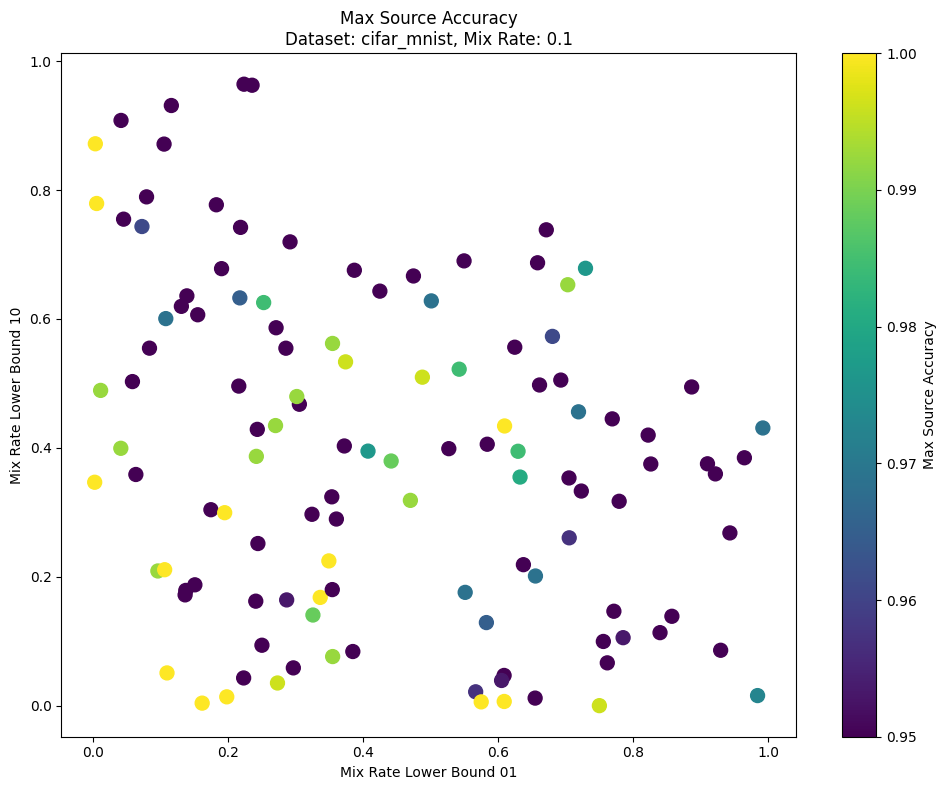

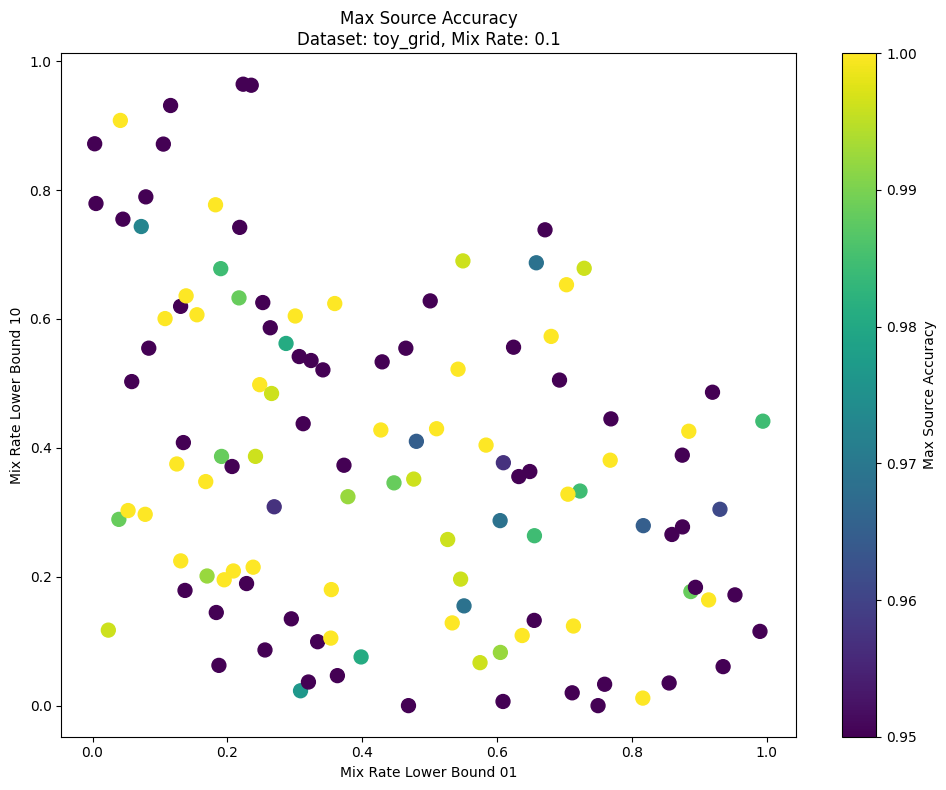

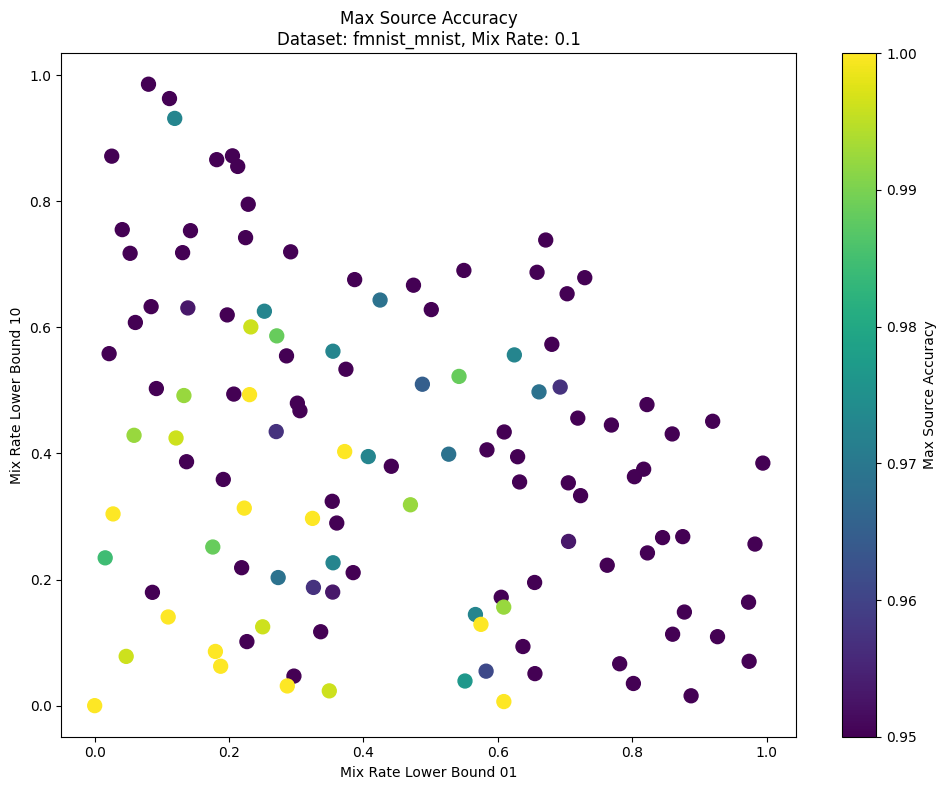

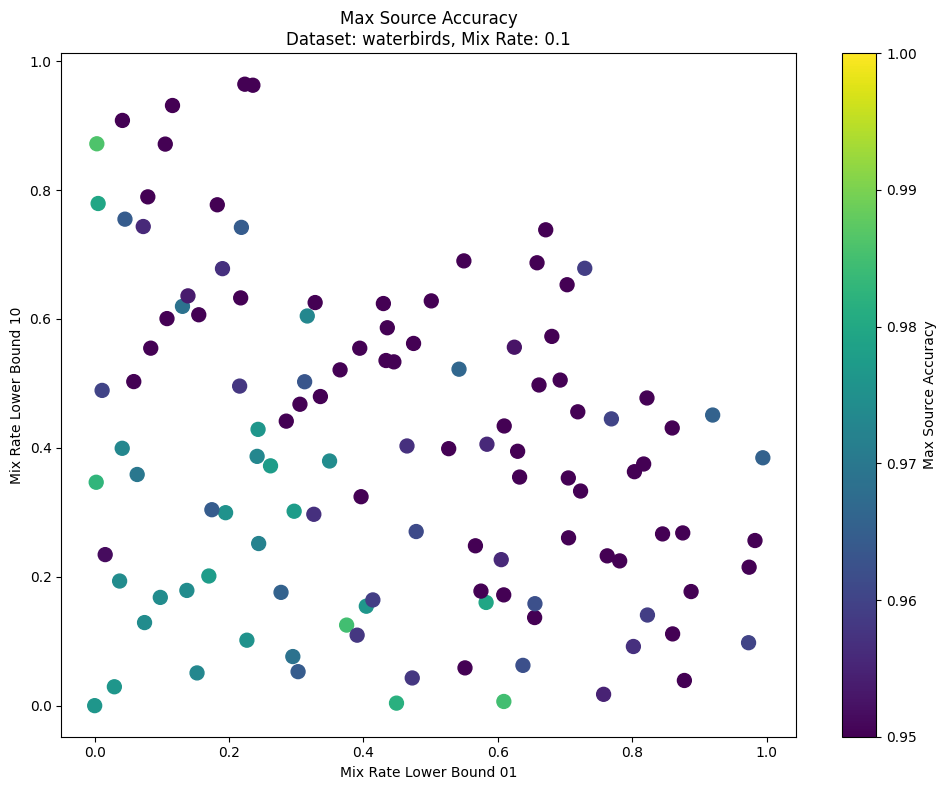

In [17]:
# Example usage:
mix_rate = 0.1
vmin = 0.95
vmax = 1.0
plot_mix_rate_accuracy(df, dataset='cifar_mnist', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='toy_grid', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='fmnist_mnist', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='waterbirds', mix_rate=mix_rate, vmin=0.95, vmax=1.0)

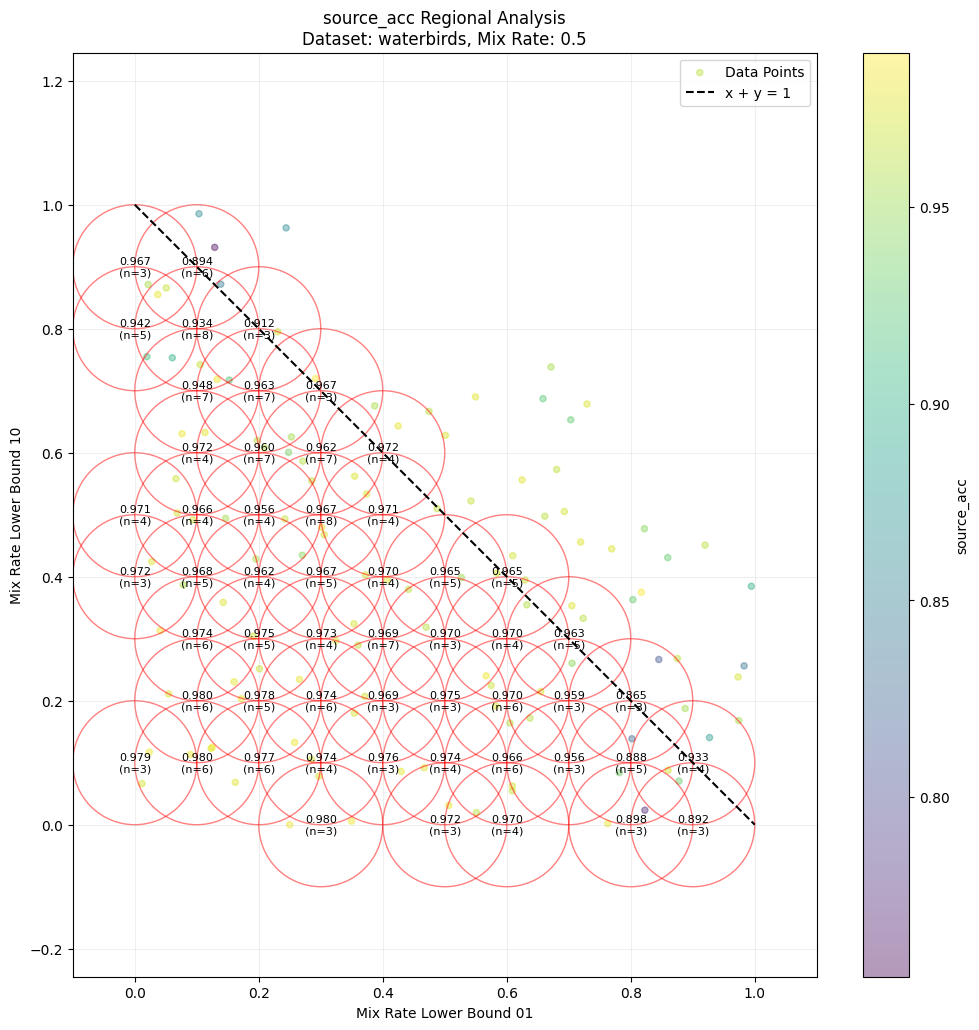

In [29]:
def analyze_accuracy_regions(df, dataset, mix_rate, metric='source_acc', 
                           radius=0.1, spacing=0.1, min_points=5):
    """
    Analyze accuracy metrics within circular regions for a given dataset and mix rate.
    
    Args:
        df: DataFrame containing results
        dataset: str, name of dataset to analyze
        mix_rate: float, mix rate to analyze
        metric: str, metric to analyze (e.g., 'source_acc', 'test_acc')
        radius: float, radius of circular regions
        spacing: float, spacing between circle centers
        min_points: int, minimum number of points required in a circle to compute statistics
    """
    # Filter data for specific dataset and mix rate
    mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
    data = df[mask]
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset} and mix_rate={mix_rate}")
        return
    
    # Create centers for circles
    x = np.arange(0, 1.1, spacing)
    y = np.arange(0, 1.1, spacing)
    centers = []
    for i in x:
        for j in y:
            if i + j <= 1:  # Only include centers below x + y = 1 line
                centers.append([i, j])
    centers = np.array(centers)
    
    # Get points
    points = np.column_stack((data['mix_rate_lb_01'], data['mix_rate_lb_10']))
    values = data[metric].values
    
    # Compute statistics for each circle
    stats = []
    for center in centers:
        # Calculate distances from center to all points
        distances = np.sqrt(np.sum((points - center)**2, axis=1))
        # Get points within radius
        mask = distances <= radius
        points_in_circle = values[mask]
        
        if len(points_in_circle) >= min_points:
            stats.append({
                'center': center,
                'n_points': len(points_in_circle),
                'mean': np.mean(points_in_circle),
                'std': np.std(points_in_circle),
                'min': np.min(points_in_circle),
                'max': np.max(points_in_circle)
            })
    
    # Create plot
    plt.figure(figsize=(12, 12))
    
    # Plot original points
    plt.scatter(points[:, 0], points[:, 1], 
               c=values, cmap='viridis', 
               alpha=0.4, s=20, 
               label='Data Points')
    
    # Plot circles and add mean text
    for stat in stats:
        center = stat['center']
        circle = plt.Circle(center, radius, fill=False, color='red', alpha=0.5)
        plt.gca().add_patch(circle)
        # Add mean text
        plt.text(center[0], center[1], 
                f"{stat['mean']:.3f}\n(n={stat['n_points']})", 
                horizontalalignment='center', 
                verticalalignment='center',
                fontsize=8)
    
    # Plot constraint line x + y = 1
    x = np.linspace(0, 1, 100)
    y = 1 - x
    plt.plot(x, y, 'k--', label='x + y = 1')
    
    plt.xlabel('Mix Rate Lower Bound 01')
    plt.ylabel('Mix Rate Lower Bound 10')
    plt.title(f'{metric} Regional Analysis\nDataset: {dataset}, Mix Rate: {mix_rate}')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.axis('equal')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.colorbar(label=metric)
    plt.show()
    
    return stats

# Example usage:
dataset = 'waterbirds'
mix_rate = 0.5
stats = analyze_accuracy_regions(df, dataset, mix_rate, 
                               metric='source_acc',
                               radius=0.1, 
                               spacing=0.1,
                               min_points=3)

In [32]:
def find_optimal_regions(df, dataset, mix_rate, erm_mean, erm_std, 
                        radius=0.1, spacing=0.1, min_points=5):
    """
    Find regions that maintain accuracy within 1 std of ERM while maximizing mix rates.
    
    Args:
        df: DataFrame containing results
        dataset: str, name of dataset to analyze
        mix_rate: float, mix rate to analyze
        erm_mean: float, mean accuracy for ERM
        erm_std: float, standard deviation for ERM accuracy
        radius: float, radius of circular regions
        spacing: float, spacing between circle centers
        min_points: int, minimum number of points required in a circle
    """
    # Filter data
    mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
    data = df[mask]
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset} and mix_rate={mix_rate}")
        return
    
    # Create centers grid
    x = np.arange(0, 1.1, spacing)
    y = np.arange(0, 1.1, spacing)
    centers = []
    for i in x:
        for j in y:
            if i + j <= 1:
                centers.append([i, j])
    centers = np.array(centers)
    
    # Get points
    points = np.column_stack((data['mix_rate_lb_01'], data['mix_rate_lb_10']))
    values = data['source_acc'].values
    
    # Analyze each region
    valid_regions = []
    for center in centers:
        distances = np.sqrt(np.sum((points - center)**2, axis=1))
        mask = distances <= radius
        points_in_circle = values[mask]
        
        if len(points_in_circle) >= min_points:
            mean_acc = np.mean(points_in_circle)
            std_acc = np.std(points_in_circle)
            
            # Check if accuracy is within 1 std of ERM
            if mean_acc >= (erm_mean - erm_std):
                total_mix_rate = center[0] + center[1]
                min_mix_rate = min(center[0], center[1])
                
                valid_regions.append({
                    'center': center,
                    'mean_acc': mean_acc,
                    'total_mix_rate': total_mix_rate,
                    'min_mix_rate': min_mix_rate,
                    'n_points': len(points_in_circle)
                })
    
    if not valid_regions:
        print("No valid regions found")
        return None
    
    # Find regions with maximum total and minimum mix rates
    max_total = max(r['total_mix_rate'] for r in valid_regions)
    max_min = max(r['min_mix_rate'] for r in valid_regions)
    
    max_total_region = [r for r in valid_regions if r['total_mix_rate'] == max_total][0]
    max_min_region = [r for r in valid_regions if r['min_mix_rate'] == max_min][0]
    
    print(f"\nResults for {dataset} (mix_rate={mix_rate}):")
    print(f"ERM baseline: {erm_mean:.3f} ± {erm_std:.3f}")
    print("\nMaximum total mix rate region:")
    print(f"Center: ({max_total_region['center'][0]:.2f}, {max_total_region['center'][1]:.2f})")
    print(f"Total mix rate: {max_total_region['total_mix_rate']:.2f}")
    print(f"Mean accuracy: {max_total_region['mean_acc']:.3f}")
    print(f"Points in region: {max_total_region['n_points']}")
    
    print("\nMaximum minimum mix rate region:")
    print(f"Center: ({max_min_region['center'][0]:.2f}, {max_min_region['center'][1]:.2f})")
    print(f"Min mix rate: {max_min_region['min_mix_rate']:.2f}")
    print(f"Mean accuracy: {max_min_region['mean_acc']:.3f}")
    print(f"Points in region: {max_min_region['n_points']}")
    
    return max_total_region, max_min_region

# Example usage:
datasets = ['cifar_mnist', 'toy_grid', 'fmnist_mnist', 'waterbirds']
mix_rates = [0.1, 0.25, 0.5, 0.75, 1.0]

for dataset in datasets:
    for mix_rate in mix_rates:
        find_optimal_regions(
            df, 
            dataset=dataset,
            mix_rate=mix_rate,
            erm_mean=mean_source_accs[dataset],
            erm_std=std_source_accs[dataset],
            radius=0.1,
            spacing=0.1,
            min_points=5
        )

No valid regions found
No valid regions found

Results for cifar_mnist (mix_rate=0.5):
ERM baseline: 1.000 ± 0.000

Maximum total mix rate region:
Center: (0.10, 0.20)
Total mix rate: 0.30
Mean accuracy: 1.000
Points in region: 5

Maximum minimum mix rate region:
Center: (0.10, 0.10)
Min mix rate: 0.10
Mean accuracy: 1.000
Points in region: 6
No valid regions found

Results for cifar_mnist (mix_rate=1.0):
ERM baseline: 1.000 ± 0.000

Maximum total mix rate region:
Center: (0.30, 0.40)
Total mix rate: 0.70
Mean accuracy: 1.000
Points in region: 6

Maximum minimum mix rate region:
Center: (0.30, 0.30)
Min mix rate: 0.30
Mean accuracy: 1.000
Points in region: 5

Results for toy_grid (mix_rate=0.1):
ERM baseline: 0.999 ± 0.002

Maximum total mix rate region:
Center: (0.10, 0.30)
Total mix rate: 0.40
Mean accuracy: 0.998
Points in region: 6

Maximum minimum mix rate region:
Center: (0.10, 0.30)
Min mix rate: 0.10
Mean accuracy: 0.998
Points in region: 6
No valid regions found
No valid regio

## Correlation Between Source Acc and Target Acc

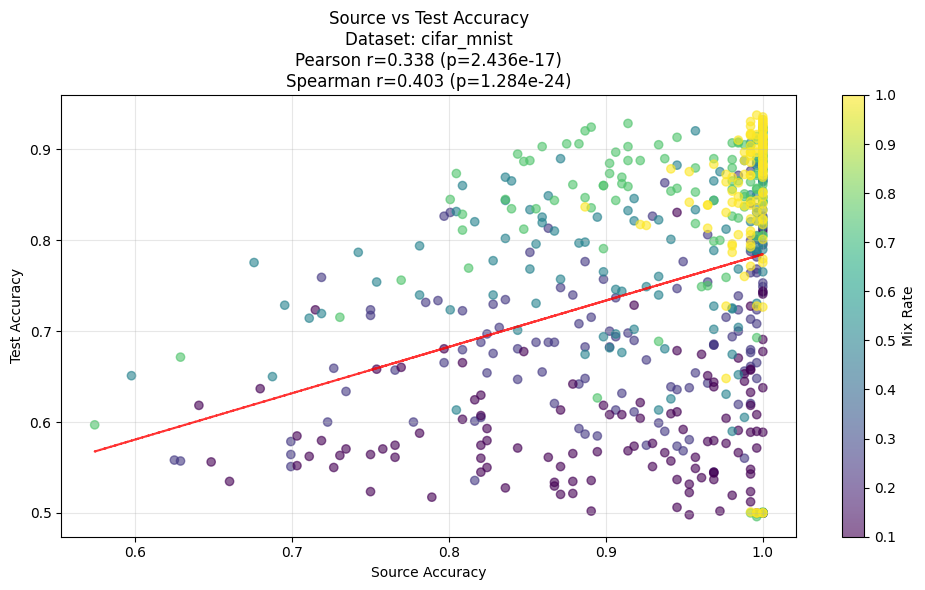

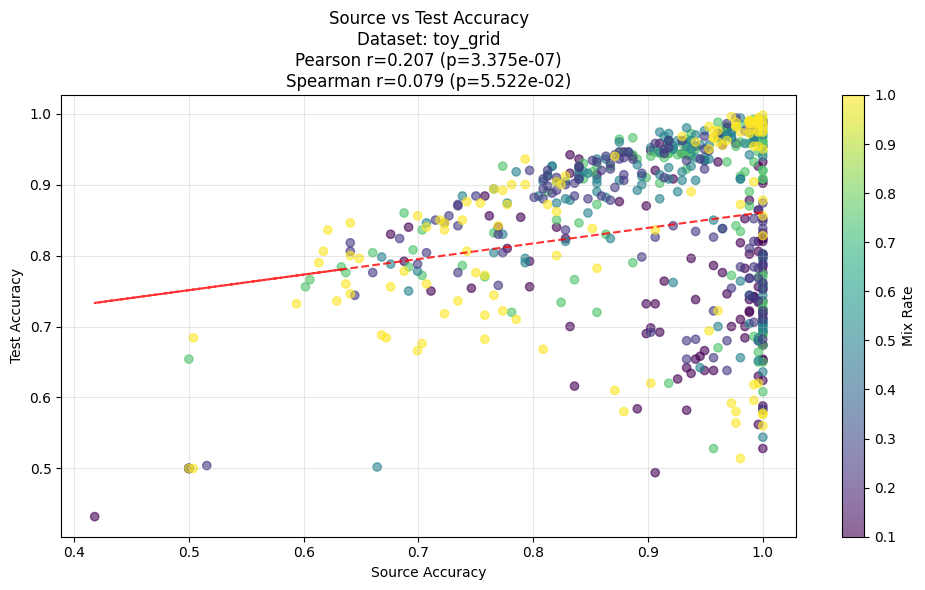

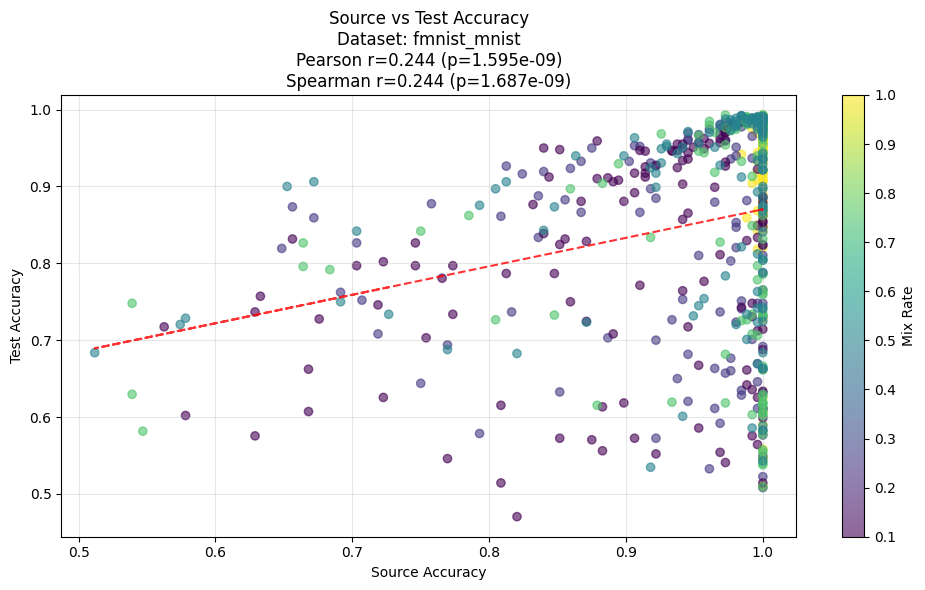

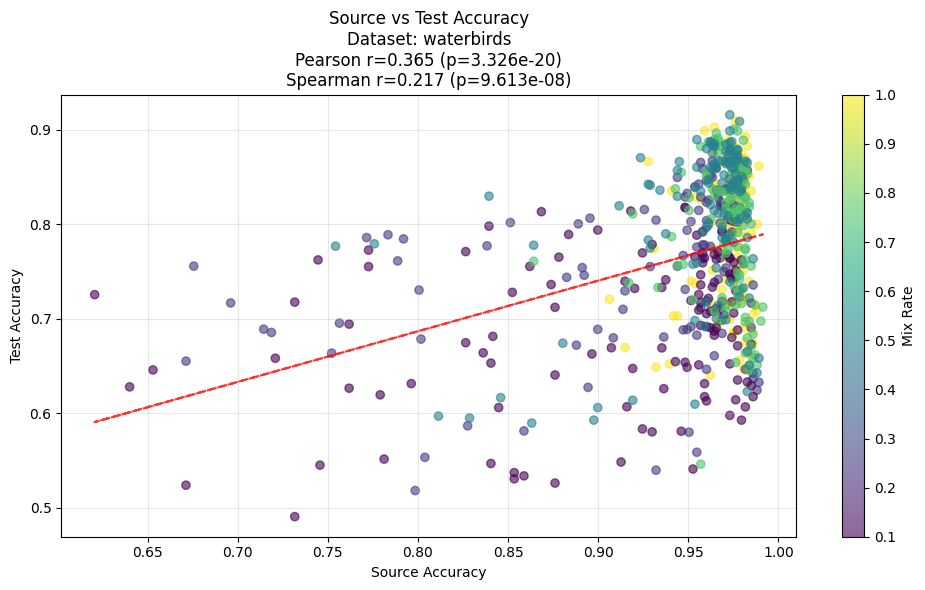

{'pearson_r': 0.3651421462796486,
 'pearson_p': 3.3263417057826496e-20,
 'spearman_r': 0.21652439308638502,
 'spearman_p': 9.612864592277381e-08}

In [33]:
def analyze_source_target_correlation(df, dataset, mix_rate=None, figsize=(10, 6)):
    """
    Analyze and plot correlation between source and target accuracy for a given dataset.
    
    Args:
        df: DataFrame containing the results
        dataset: str, name of dataset to analyze
        mix_rate: float or None, if specified, filter for specific mix rate
        figsize: tuple, size of the figure (width, height)
    """
    import matplotlib.pyplot as plt
    from scipy import stats
    
    # Filter data
    mask = df['dataset'] == dataset
    if mix_rate is not None:
        mask = mask & (df['mix_rate'] == mix_rate)
    data = df[mask]
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset}" + 
              (f" and mix_rate={mix_rate}" if mix_rate is not None else ""))
        return
    
    # Compute correlation
    pearson_r, p_value = stats.pearsonr(data['source_acc'], data['test_acc'])
    spearman_r, spearman_p = stats.spearmanr(data['source_acc'], data['test_acc'])
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Scatter plot with color based on mix rate
    scatter = plt.scatter(
        data['source_acc'],
        data['test_acc'],
        c=data['mix_rate'] if mix_rate is None else data['mix_rate_lb_01'],
        cmap='viridis',
        alpha=0.6
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Mix Rate' if mix_rate is None else 'Mix Rate LB 01')
    
    # Add correlation line
    z = np.polyfit(data['source_acc'], data['test_acc'], 1)
    p = np.poly1d(z)
    plt.plot(data['source_acc'], p(data['source_acc']), "r--", alpha=0.8)
    
    # Labels and title
    plt.xlabel('Source Accuracy')
    plt.ylabel('Test Accuracy')
    title = f'Source vs Test Accuracy\nDataset: {dataset}'
    if mix_rate is not None:
        title += f'\nMix Rate: {mix_rate}'
    title += f'\nPearson r={pearson_r:.3f} (p={p_value:.3e})'
    title += f'\nSpearman r={spearman_r:.3f} (p={spearman_p:.3e})'
    plt.title(title)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {
        'pearson_r': pearson_r,
        'pearson_p': p_value,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p
    }

# Example usage:
# For all mix rates:
analyze_source_target_correlation(df, dataset='cifar_mnist')
analyze_source_target_correlation(df, dataset='toy_grid')
analyze_source_target_correlation(df, dataset='fmnist_mnist')
analyze_source_target_correlation(df, dataset='waterbirds')

## Correlation Between Min(Mix Rate LB - Mix RATE, 0) and Source Acc

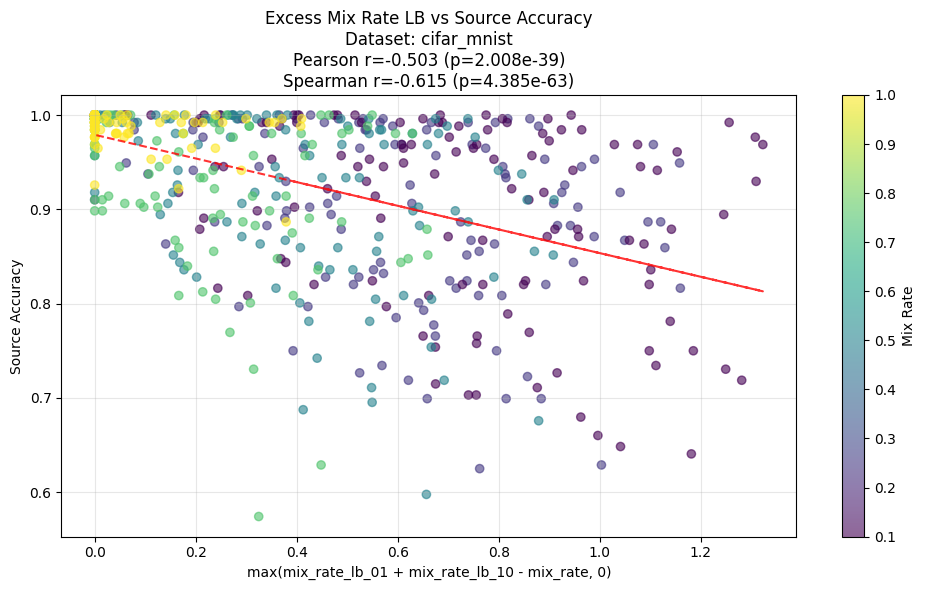

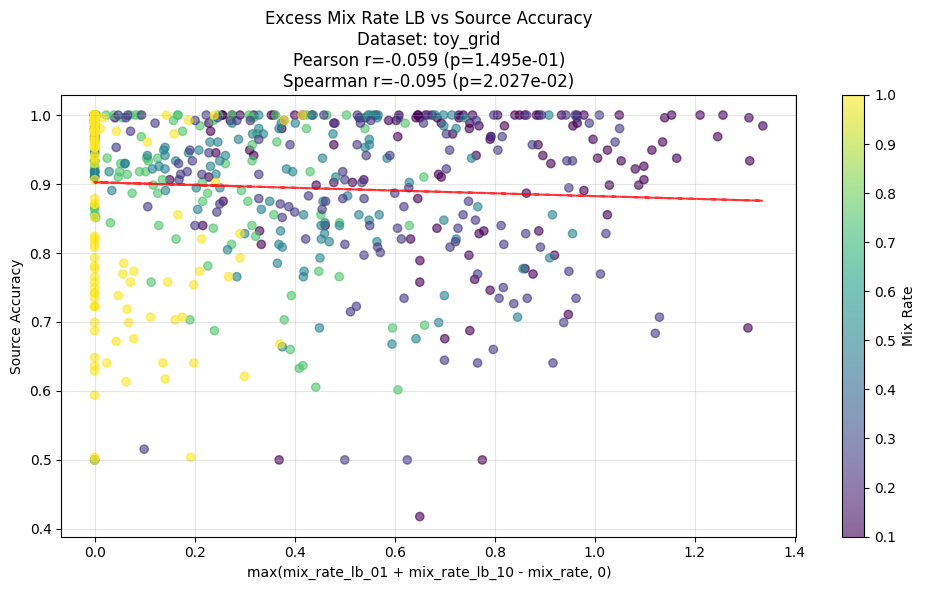

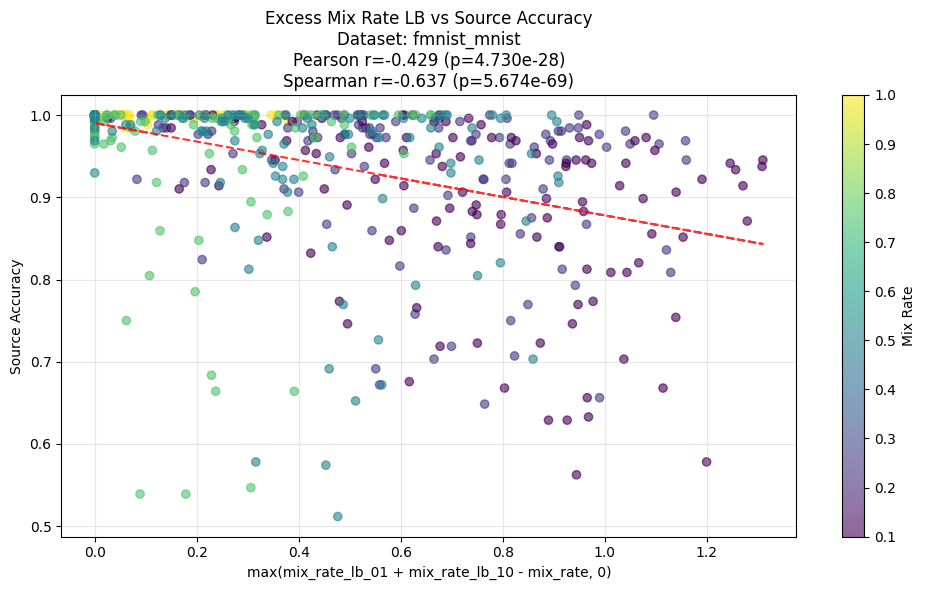

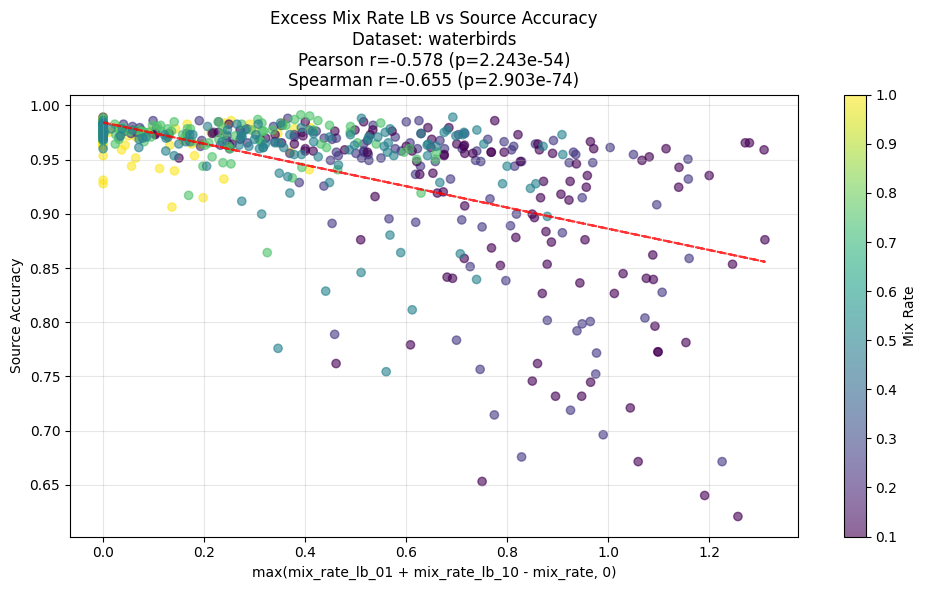

In [34]:
def analyze_mix_rate_lb_correlation(df, dataset, mix_rate=None, figsize=(10, 6)):
    """
    Analyze and plot correlation between excess mix rate lower bound and source accuracy.
    
    Args:
        df: DataFrame containing the results
        dataset: str, name of dataset to analyze
        mix_rate: float or None, if specified, filter for specific mix rate
        figsize: tuple, size of the figure (width, height)
    """
    import matplotlib.pyplot as plt
    from scipy import stats
    
    # Filter data
    mask = df['dataset'] == dataset
    if mix_rate is not None:
        mask = mask & (df['mix_rate'] == mix_rate)
    data = df[mask].copy()  # Create copy to avoid SettingWithCopyWarning
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset}" + 
              (f" and mix_rate={mix_rate}" if mix_rate is not None else ""))
        return
    
    # Calculate excess mix rate lower bound
    data['excess_mix_rate_lb'] = np.maximum(
        data['mix_rate_lb_01'] + data['mix_rate_lb_10'] - data['mix_rate'],
        0
    )
    
    # Compute correlation
    pearson_r, p_value = stats.pearsonr(data['excess_mix_rate_lb'], data['source_acc'])
    spearman_r, spearman_p = stats.spearmanr(data['excess_mix_rate_lb'], data['source_acc'])
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Scatter plot
    scatter = plt.scatter(
        data['excess_mix_rate_lb'],
        data['source_acc'],
        c=data['mix_rate'],
        cmap='viridis',
        alpha=0.6
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Mix Rate')
    
    # Add correlation line
    z = np.polyfit(data['excess_mix_rate_lb'], data['source_acc'], 1)
    p = np.poly1d(z)
    plt.plot(data['excess_mix_rate_lb'], p(data['excess_mix_rate_lb']), "r--", alpha=0.8)
    
    # Labels and title
    plt.xlabel('max(mix_rate_lb_01 + mix_rate_lb_10 - mix_rate, 0)')
    plt.ylabel('Source Accuracy')
    title = f'Excess Mix Rate LB vs Source Accuracy\nDataset: {dataset}'
    if mix_rate is not None:
        title += f'\nMix Rate: {mix_rate}'
    title += f'\nPearson r={pearson_r:.3f} (p={p_value:.3e})'
    title += f'\nSpearman r={spearman_r:.3f} (p={spearman_p:.3e})'
    plt.title(title)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {
        'pearson_r': pearson_r,
        'pearson_p': p_value,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p
    }

# Example usage:
for dataset in ['cifar_mnist', 'toy_grid', 'fmnist_mnist', 'waterbirds']:
    analyze_mix_rate_lb_correlation(df, dataset=dataset)

# Sett

In [ ]:
# can I make this into a score? 

# no 


# ok just look else where for the mean,std erm 

# bin the mix rates into 10 bins 
# compute mean across bins for each dataset and mix rate 
# compute highest assumed mix rate within one standard deviation 
# 

In [ ]:
# so there's signal here, its just a matter of setting thresholds
# I think 